# IA315 Multimodal Dialogue: Dynamic Time Warping  
  
Thomas Jacquemin  
MS IA 2019-2020

In [1]:
import os
import numpy as np
import random

from scipy.io import wavfile

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

How to calculate a measure of similarity between two sequences that takes into account the Time distortions? We will see in this notebook an implementation of  DTW (Dynamic Time Warping) which calculates the optimal path in the similarity matrix of two sequences

## 1. Data  
  
The directory `DATA` contains three directories:

* `SIG` contains 12 repetitions of numbers from 0 to 9 by speaker1 ($Fe = 8000$kHz). `SIG_Rep_5_Number_3.wav` is the recording corresponding to the fifth repetition of the number “3”.
* `SIG_MIXED` contains 6 repetitions of the number by speaker1 (`SIG_MIXED_Rep_1:6`) and then by speaker2 (`SIG_MIXED_Rep_7:12`).

## 2. Speech Feature Extraction  
  
We will Write a python script to calculate the cepstral parameterization associated with each pronunciation.  
For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:  
  
  $$number\ of\ cepstral\ vectors \begin{pmatrix}
X_1 (1st\ vector) ({line\ vector}) \\
X_2 (second\ vector) \\
\vdots \\
X_{lX} (last\ vector) 
\end{pmatrix}$$
$$\hspace{4cm} p$$

In [2]:
def cepstral_representation(audio_signal, window_size, window_shift, p):
    
    cepstral_matrix = []
    index = 0
    while (index + window_size) <= len(audio_signal):
        
        # Get window signal
        window = np.arange(index, index + window_size)
        signal_window = audio_signal[window]
        
        # FFT
        spectrum = np.fft.fft(signal_window)
        
        # Hanning Filter
        spectrum_filtered = np.hanning(window_size) * spectrum
        
        # Take the log
        realmin = np.finfo(np.double).tiny
        log_spectrum = np.log(abs(spectrum_filtered + realmin))
        
        # iFFT
        cepstrum = np.real(np.fft.ifft(log_spectrum))
        
        # Adding p points
        cepstral_matrix.append(np.array(cepstrum[:p]))
        
        index += window_shift
    
    return np.array(cepstral_matrix)

Regard to the parameters of the analysis, the following choices will be preferred :

In [3]:
window_size = 256
window_shift = 128
p = 10

## 3. Time alignment by dynamic programming  
  
We will now write a python function performing time alignment by dynamic programming between two sequences
of vectors stored with the above convention.  
  
The function will process as follows:  
  
**Inputs**: The two vector sequences $(X_1, \cdots , X_{lX})$ and $(Y_1, \cdots , Y_{lY})$ stored in the two matrices, as well as a parameter $\gamma$.  

**Calculation of the similarity matrix**: Given the two vector sequences, this is the matrix $D(l_X \times l_Y)$ such that $D(i, j) = ||X_i − Y_j||$.  
  
**Initialization of the cumulative distance matrix**: First row and column of the cumulative distance matrix $C(l_X \times l_Y )$ such that $C(i, j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i, j)$ at the initial node $(1, 1)$.  
  
**Calculation of the matrix of cumulative distances**:  **This is the dynamic programming part. We don't want to test all the possible deformation paths, and we rather obtain the optimal solution from intermediate solutions.  Theses optimal intermediate solutions are obtained through an iterative process which allows to calculate the minimum distance between each subsequence
possible X, and each possible subsequence of Y. We calculate theses solutions for each index of the matrix, taking the optimal solution either from the left in the matrix, or above, or even following the diagonal.  
we can use a “code” representing the three possible predecessors: 0 if we come from above, 1 if it's from the left and 2 in diagonal.**  
  
**Bactracking**: From the node $(l_X, l_Y )$, reconstruction of the optimal path (starting from the end).

**Outputs**: The cumulative distance along the path of least cost and the alignment path.

In [4]:
def DTW(X, Y, gamma=1):
    
    shape = (len(X), len(Y))
    # Similarity matrix
    D = np.zeros(shape)
    for i in range(len(X)):
        for j in range(len(Y)):
            D[i, j] = np.linalg.norm(X[i] - Y[j])**2
            
    # Cumulative distance matrix initialization
    C = np.zeros(shape)
    backtrack = np.zeros(shape)
    C[0, 0] = D[0, 0]
    backtrack[0, 0] = -1
    # First column init
    for i in range(1, len(X)):
        C[i, 0] = D[i, 0] + C[i-1, 0]
        backtrack[i, 0] = 0
    # First line init
    for j in range(1, len(Y)):
        C[0, j] = D[0, j] + C[0, j-1]
        backtrack[0, j] = 1
        
    # Dynamic cumulative distances matrix
    for i in range(1, len(X)):
        for j in range(1, len(Y)):
            distances = [D[i, j] + C[i-1, j], D[i, j] + C[i, j-1], gamma * D[i, j] + C[i-1, j-1]]
            C[i, j], backtrack[i, j] = min(distances), np.argmin(distances)
            
    # Backtracking path
    path = []
    i, j = len(X)-1, len(Y)-1
    path.append([i, j])
    while True:
        last_node = backtrack[i, j]
        if last_node == 0:
            i -= 1
        elif last_node == 1:
            j -= 1
        elif last_node == 2:
            i -= 1
            j -= 1
        elif last_node == -1:
            break
        path.append([i, j])

    # Reverse path
    path = path[::-1]
    
    return C[len(X)-1, len(Y)-1], path, C, D

### Quick test

In [5]:
Y = [1, 2, 2, 4, 6]
X = [1, 2, 4, 4, 6, 6]
distance, path, cumulative_matrix, distance_matrix = DTW(X, Y, gamma=2)

print('Cumulative distance: {} \n'.format(distance))
print('Optimal path: {} \n'.format(path))
print('Cumulative distance matrix C: \n {} \n'.format(cumulative_matrix))
print('Distance matrix D: \n {} \n'.format(distance_matrix))

Cumulative distance: 0.0 

Optimal path: [[0, 0], [1, 1], [1, 2], [2, 3], [3, 3], [4, 4], [5, 4]] 

Cumulative distance matrix C: 
 [[ 0.  1.  2. 11. 36.]
 [ 1.  0.  0.  4. 20.]
 [10.  4.  4.  0.  4.]
 [19.  8.  8.  0.  4.]
 [44. 24. 24.  4.  0.]
 [69. 40. 40.  8.  0.]] 

Distance matrix D: 
 [[ 0.  1.  1.  9. 25.]
 [ 1.  0.  0.  4. 16.]
 [ 9.  4.  4.  0.  4.]
 [ 9.  4.  4.  0.  4.]
 [25. 16. 16.  4.  0.]
 [25. 16. 16.  4.  0.]] 



In [6]:
Y = [1, 2, 2, 4, 6]
X = [2, 3, 4, 5, 6, 7]
distance, path, cumulative_matrix, distance_matrix = DTW(X, Y, gamma=2)

print('Cumulative distance: {} \n'.format(distance))
print('Optimal path: {} \n'.format(path))
print('Cumulative distance matrix C: \n {} \n'.format(cumulative_matrix))
print('Distance matrix D: \n {} \n'.format(distance_matrix))

Cumulative distance: 4.0 

Optimal path: [[0, 0], [0, 1], [0, 2], [1, 2], [2, 3], [3, 3], [4, 4], [5, 4]] 

Cumulative distance matrix C: 
 [[ 1.  1.  1.  5. 21.]
 [ 5.  2.  2.  3. 12.]
 [14.  6.  6.  2.  6.]
 [30. 15. 15.  3.  4.]
 [55. 31. 31.  7.  3.]
 [91. 56. 56. 16.  4.]] 

Distance matrix D: 
 [[ 1.  0.  0.  4. 16.]
 [ 4.  1.  1.  1.  9.]
 [ 9.  4.  4.  0.  4.]
 [16.  9.  9.  1.  1.]
 [25. 16. 16.  4.  0.]
 [36. 25. 25.  9.  1.]] 



# 4. Application to speech data

We can test the algorithm with the data presented in the first part.  
First we can align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others.

In [7]:
def get_coefs_from_file(path):
    """Directly get cepstral parameterization of
       an audio signal given its file path"""
    
    _, audio_signal = wavfile.read(path)
    return cepstral_representation(audio_signal, window_size, window_shift, p)

# Our reference audio signal: 1st repetition of the number 0 
data_folder = './Data/SIG/'
reference_file = 'SIG_Rep_1_Number_0.wav'

X = get_coefs_from_file(data_folder + reference_file)

We can now align this sequence with all of the other files.

In [8]:
def align_reference_with_others(reference, data_folder, other_files, DTW, gamma):

    distances = []

    # We will track the number in the name of the audio file
    # to display a different color for each number
    numbers = []

    for f in other_files:
        if f == reference_file:
            continue

        number = int(f[-5])

        Y = get_coefs_from_file(data_folder + f)

        distance, _, _, _ = DTW(reference, Y, gamma)
        distances.append(distance)
        numbers.append(number)
        
    colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red', 4: 'purple', 5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan'}

    plt.figure(figsize=(10,6))
    plt.bar(np.arange(len(distances)), distances, color=list(map(lambda x: colors[x], numbers)))
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    plt.xlabel('Audio Signal')
    plt.ylabel('Similarity Distance')
    plt.show()

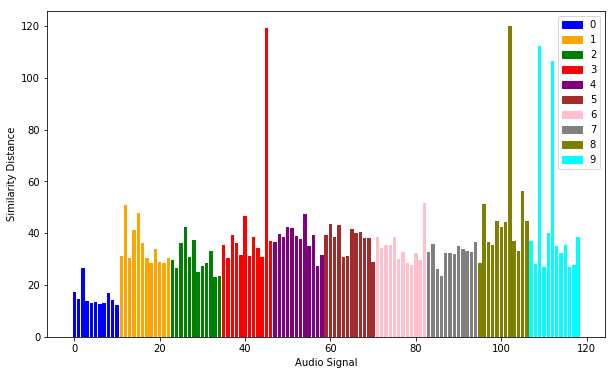

In [9]:
files = os.listdir(data_folder)
files.remove(reference_file)
# Sorting files by number
files.sort(key=lambda x: x[-5])

align_reference_with_others(X, data_folder, files, DTW, gamma=2)

It is very clear that the average distance between the reference audio file and those corresponding to the number 0 are much closer in terms of similarity distance (distances in blue in the graph). 
The discrimination performance is satisfactory, since the reference audio signal corresponds to the repetition of the number 0.

In the DTW algorithm, we had a `gamma` parameter which penalizes the diagonal direction in the dynamic evaluation of the next iteration of the optimal path. 
A low gamma favors the choice of the diagonal, and thus of the linearity in the correspondence of the sequences. This is not really a case that is often encountered in real data. A gamma below 1 can even make sequences look more similar than they really are: the discrimination criterion will be less effective.

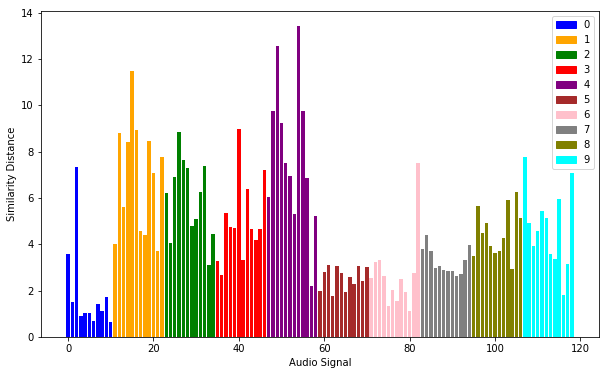

In [10]:
align_reference_with_others(X, data_folder, files, DTW, gamma=0.01)

On the other hand, a higher gamma will favour the exploration of distortions between the two signals. This can be a good thing, since words are not always pronounced at the same speed or in the same way. (But if it's too high we may favour these distortions too much, and we risk to have a poorer performance.)  
  
We will continue with `gamma = 2`.

**Note on the use of Euclidian distance for similarity:**  
  
Choosing the euclidan distance gives equal importance to all the features in the cepstral parametrization. This hypothesis may seem acceptable in view of the differences between aligned sequences corresponding to different repetitions of the same word, but maybe a proper weighting for the coefficient could improve the performance.

# 5. Evaluation of speech recognition

We will try to evaluate the discrimination performance in different situations described by different protocols, to see if we can use a "training" set to predict and therefore recognize a new "test" audio signal.

In [11]:
def get_distances(x, X_train, DTW, gamma):
    """ Get similarity distances computed with
    Dynamic Time Wrapping method DTW (with gamma parameter)
    between the cepstral parameterization of x and an entire training set"""
    
    distances = []
    for y in X_train:
        distance, _, _, _ = DTW(x, y, gamma)
        distances.append(distance)
    return np.array(distances)

## Protocol 1  
  
The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the training set and the remaining subset (1/3 of repetitions) is used for the test set. The procedure is repeated by rotating the test and training sets.

In [12]:
def run_protocol_1(DTW, gamma):
    data_folder = './Data/SIG/'
    files = os.listdir(data_folder)
    random.shuffle(files)

    X = np.array(list(map(lambda x: get_coefs_from_file(data_folder + x), files)))
    y = np.array(list(map(lambda x: int(x[-5]), files)))
    
    kf = KFold(n_splits=3)

    y_pred = []
    current_fold = 1
    for train_index, test_index in kf.split(X, y):
        print('Kfold: {}/3'.format(current_fold))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold_predictions = []
        for x in X_test:
            distances = get_distances(x, X_train, DTW, gamma)
            prediction = y_train[np.argmin(distances)]
            fold_predictions.append(prediction)
        y_pred.extend(fold_predictions)
        current_fold += 1
        
    return y, y_pred

## Protocol 2  
  
A database containing only one pronunciation of each number is used as a training database. The remaining repetitions are used for the test set. This procedure aims at evaluating the generalization capabilities of the recognition system.

In [13]:
def run_protocol_2(DTW, gamma):
    data_folder = './Data/SIG/'
    files = os.listdir(data_folder)
    
    train_files = []
    for number in range(10):
        files.remove('SIG_Rep_1_Number_{}.wav'.format(number))
        train_files.append('SIG_Rep_1_Number_{}.wav'.format(number))

    X_train = np.array(list(map(lambda x: get_coefs_from_file(data_folder + x), train_files)))
    y_train = np.array(list(map(lambda x: int(x[-5]), train_files)))
    
    X_test = np.array(list(map(lambda x: get_coefs_from_file(data_folder + x), files)))
    y_test = np.array(list(map(lambda x: int(x[-5]), files)))
    
    y_pred = []
    for x in X_test:
        distances = get_distances(x, X_train, DTW, gamma)
        prediction = y_train[np.argmin(distances)]
        y_pred.append(prediction)
        
    return y_test, y_pred

## Protocol 3  
  
The first half of the database of `SIGMIX` is used as a training database and the second half as the test database. The procedure is repeated by inversing the role of the two sets. This procedure aims at evaluating the generalization capabilities on a database containing data from the two speakers.

In [14]:
def run_protocol_3(DTW, gamma):
    data_folder = './Data/SIGMIX/'
    files = os.listdir(data_folder)
    # Sorting files by repetition number
    files.sort(key=lambda x: x[len('SIGMIX_Rep_')])
    
    # Splitting Train Test
    half = len(files)//2
    test_files = files[:half]
    train_files = files[half:]
    
    y_true = np.array(list(map(lambda x: int(x[-5]), files)))
    
    X_train = np.array(list(map(lambda x: get_coefs_from_file(data_folder + x), train_files)))
    y_train = np.array(list(map(lambda x: int(x[-5]), train_files)))
    
    X_test = np.array(list(map(lambda x: get_coefs_from_file(data_folder + x), test_files)))
    y_test = np.array(list(map(lambda x: int(x[-5]), test_files)))
    
    y_pred = []
    swap_train_test = False
    while True:
        print('First speaker: {} | Second speaker: {}\n'.format('Test' if not swap_train_test else 'Train',
                                                                'Train' if not swap_train_test else 'Test'))
        for x in X_test:
            distances = get_distances(x, X_train, DTW, gamma)
            prediction = y_train[np.argmin(distances)]
            y_pred.append(prediction)
            
        if swap_train_test == True:
            break
        swap_train_test = True
        print('Swapping Test and Train sets\n')
        X_train, y_train, X_test, y_test = X_test, y_test, X_train, y_train 
        
    return y_true, y_pred

## Protocols analysis

In [15]:
def evaluation_recognition(DTW_cback=DTW, gamma=1, protocol=1):
    
    print('==== Evaluation of Speech Recognition for protocol {} ====\n'.format(protocol))
    
    if protocol == 1:
        print('3 folds validation\n')
        y_true, y_pred = run_protocol_1(DTW_cback, gamma)
        
    elif protocol == 2:
        print('Generalization (small training set: one rep for each number)\n')
        y_true, y_pred = run_protocol_2(DTW_cback, gamma)
        
    elif protocol == 3:
        print('Generalization (data from two speakers)\n')
        y_true, y_pred = run_protocol_3(DTW_cback, gamma)
        
    else:
        return
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print('==== Results ====\n')
    print('Accuracy Score: {}\n\n'.format(accuracy))
    print('Confusion Matrix: \n{}\n'.format(conf_matrix))
    
    return conf_matrix, accuracy_score

In [16]:
for protocol_number in [1, 2, 3]:
    if(protocol_number != 1): print('\n******************************************\n')
    evaluation_recognition(gamma=2, protocol=protocol_number)

==== Evaluation of Speech Recognition for protocol 1 ====

3 folds validation

Kfold: 1/3
Kfold: 2/3
Kfold: 3/3
==== Results ====

Accuracy Score: 0.975


Confusion Matrix: 
[[12  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  1]
 [ 0  0  0  0 12  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  1  1 10  0]
 [ 0  0  0  0  0  0  0  0  0 12]]


******************************************

==== Evaluation of Speech Recognition for protocol 2 ====

Generalization (small training set: one rep for each number)

==== Results ====

Accuracy Score: 0.6636363636363637


Confusion Matrix: 
[[11  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  2]
 [ 0  0  4  0  0  0  0  0  0  7]
 [ 0  0  0  9  0  0  0  0  0  2]
 [ 0  0  2  0  5  0  0  3  0  1]
 [ 0  0  0  0  0  9  0  2  0  0]
 [ 0  0  0  0  0  0 10  1  0  0]
 [ 0  0  0  0  0  6  0

**Protocol 1**:
  It can be seen that for the first evaluation protocol, the performance is very good. A gamma parameter of 2 gives 0.97% of accuracy. There is still some confusion for short single-syllable words.
  
**Protocol 2**:
  The second protocol highlights the fact that when there is very little training data, performance drops drastically. The discriminant factor still requires a sufficient amount of data for the model to be generalized.
  
**Protocol 3**:
  Finally, the last protocol shows that the recognition performance is not so bad for two speakers who pronounce the words at slightly different frequencies, with 85% of accuracy.

The algorithm works quite well, as long as there is enough data to align the sequence to be recognized with different types of sequences for the same word. However we are dealing here with very short words, we should look at what we would get on longer sequences and words. Finally, it should be noted that this technique is quite expensive in computing time (here we have predicted only 120 repetitions in a significant amount of time).